<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#A/B-Testing-Case-Study" data-toc-modified-id="A/B-Testing-Case-Study-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>A/B Testing Case Study</a></span><ul class="toc-item"><li><span><a href="#Project-Summary" data-toc-modified-id="Project-Summary-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Project Summary</a></span></li><li><span><a href="#Data-and-Analysis" data-toc-modified-id="Data-and-Analysis-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Data and Analysis</a></span><ul class="toc-item"><li><span><a href="#Data-Cleaning-and-EDA" data-toc-modified-id="Data-Cleaning-and-EDA-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Data Cleaning and EDA</a></span></li><li><span><a href="#Test-and-Control-Group-Assignment" data-toc-modified-id="Test-and-Control-Group-Assignment-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Test and Control Group Assignment</a></span></li><li><span><a href="#Conversion-Rates" data-toc-modified-id="Conversion-Rates-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Conversion Rates</a></span></li><li><span><a href="#Statistical-Testing" data-toc-modified-id="Statistical-Testing-1.2.4"><span class="toc-item-num">1.2.4&nbsp;&nbsp;</span>Statistical Testing</a></span><ul class="toc-item"><li><span><a href="#Statistical-Framework" data-toc-modified-id="Statistical-Framework-1.2.4.1"><span class="toc-item-num">1.2.4.1&nbsp;&nbsp;</span>Statistical Framework</a></span></li><li><span><a href="#Power-Analysis" data-toc-modified-id="Power-Analysis-1.2.4.2"><span class="toc-item-num">1.2.4.2&nbsp;&nbsp;</span>Power Analysis</a></span></li><li><span><a href="#Hypothesis-Testing" data-toc-modified-id="Hypothesis-Testing-1.2.4.3"><span class="toc-item-num">1.2.4.3&nbsp;&nbsp;</span>Hypothesis Testing</a></span></li></ul></li></ul></li></ul></li></ul></div>

## A/B Testing Case Study

This notebook contains an extract of an A/B test I conducted on web load data. I have generalized the description of the case study to keep it anonymized.

### Project Summary

The client is interested in improving their checkout flow. Currently, the checkout flow involves **three separate steps**. The A/B test aims to test a potential improvement to the first step that hopefully will improve conversion in this step.

In the first step of the checkout flow, customers complete a 6 field form in order to proceed to the next checkout step. The client wants to test introducing a feature that reduces the number of fields in the form from 6 to 5. Rather than asking each applicant to fill in the 6th field, we can use a data vendor to look this up based on the other information entered by the customer for a cost of $2 per customer.

The client conducts a split test that diverts on form loads. During the test, 50\% of forms will load as the 6 field form and the other 50\% will load as a 5 field form.

What is the impact of this change?

### Data and Analysis

#### Data Cleaning and EDA

In [1]:
# Import packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
# Read data
loads = pd.read_csv('data/loads.csv', parse_dates=True) # DF of all web loads
testGroup = pd.read_csv('data/test_group.csv', parse_dates=True) # DF identifying test group observations

`loads` contains 190830 observations of loads of all versions of the form. Each observation is identified by a unique id (`load_id`) and contains data on the load's date (`load_date`), whether the load resulted in a completion of the first checkout step (`completed_form`) and second checkout step (`completed_second`), and whether the customer completed checkout (each checkout identified by a `checkout_id`).

In [3]:
loads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190830 entries, 0 to 190829
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Unnamed: 0        190830 non-null  int64 
 1   load_id           190830 non-null  object
 2   checkout_id       49323 non-null   object
 3   load_date         190830 non-null  object
 4   completed_form    190830 non-null  int64 
 5   completed_second  190830 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 8.7+ MB


`testGroup` identifies 8495 loads of the 5-field form. Each observation identifies the `load_id` associated with observations assigned to the test group and the date of the load (`assignment_date`). We notice that the only 8495 observations are from the test group, which probably means that our `loads` data contains many more observations than an assumed 50-50 split experiment.

In [4]:
testGroup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8495 entries, 0 to 8494
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       8495 non-null   int64 
 1   load_id          8495 non-null   object
 2   assignment_date  8495 non-null   object
dtypes: int64(1), object(2)
memory usage: 199.2+ KB


Before exploring the number of observations in the `loads` and `testGroup` data, we merge them to identify the relevant control and test observations in our experiment. We transform `load_date` and `assignment_date` into datetime type, drop the column `Unnamed:0` as it was an index column from the original csv files, and then merge `loads` and `testGroup` dataframes together on the unique `load_id` identifier. We find that all 8495 observations from the test group successfully merge.

In [5]:
# Transform date columns into datetime
loads['load_date'] = pd.to_datetime(loads['load_date'])
testGroup['assignment_date'] = pd.to_datetime(testGroup['assignment_date'])

# Drop index columns
loads.drop('Unnamed: 0', axis=1, inplace=True)
testGroup.drop('Unnamed: 0', axis=1, inplace=True)

# Merge prequals with intellicron_prequals
mergedDF = pd.merge(loads, testGroup, how='outer', on='load_id', indicator=True)

print('{} observations successfully merged'.format(sum(mergedDF['_merge']=='both')))

8495 observations successfully merged


After merging, we separate our data into two data frames. `test` includes all observations in the test group. `control` includes all observations not identified to be part of the test group.

In [6]:
# Get control and test data
test = mergedDF.loc[mergedDF['_merge'] == 'both', mergedDF.columns != '_merge']
control = mergedDF.loc[mergedDF['_merge'] == 'left_only', mergedDF.columns != '_merge']

#### Test and Control Group Assignment

The client did not give us any information on when they ran the experiment, so we investigate the date range of the experiment test group and compare it to our control group. We find that the experiment ranged from 2019-06-16 to 2019-06-30, while the control group contained data from 2019-01-01 to 2019-06-30. We have many observations of pre-experiment data of the 6-field form which can explain why the control group contains more observations.

In [7]:
# Check the test period
testStart = test['load_date'].min()
testEnd = test['load_date'].max()
print('Test started {} and ended {}'.format(testStart, testEnd))

# Check control period
controlStart = control['load_date'].min()
controlEnd = control['load_date'].max()
print('Control date range started {} and ended {}'.format(controlStart, controlEnd))

Test started 2019-06-16 00:00:00 and ended 2019-06-30 00:00:00
Control date range started 2019-01-01 00:00:00 and ended 2019-06-30 00:00:00


From the dates analysis, we assume that the experiment occured between 2019-06-16 and ended 2019-06-30 and drop all observations from the control group outside of this date range.

In [8]:
# Get pre-experiment data
pre = control[control['load_date'] < testStart]
# Only get control observations during the test period
control = control[(control['load_date'] >= testStart) & (control['load_date'] <= testEnd)]

After deleting the pre-experiment data, however, we still find a relatively large imbalance in the control and test sample sizes. The control group has 1,195 more observations than the test group.

In [9]:
# Check observations
nControl = len(control)
nTest = len(test)

print('There are {} total trials'.format(nControl + nTest))
print('There are {} observations in the control group'.format(nControl))
print('There are {} observations in the test group'.format(nTest))
print('There are {} more observations in the control group than the test group'.format(nControl-nTest))

There are 18185 total trials
There are 9690 observations in the control group
There are 8495 observations in the test group
There are 1195 more observations in the control group than the test group


From plotting the observations across the test and control group, we can see that the client is consistently assigning more loads to the control group on every day of the experiment, so there is likely a non-random splitting process going on in the background.

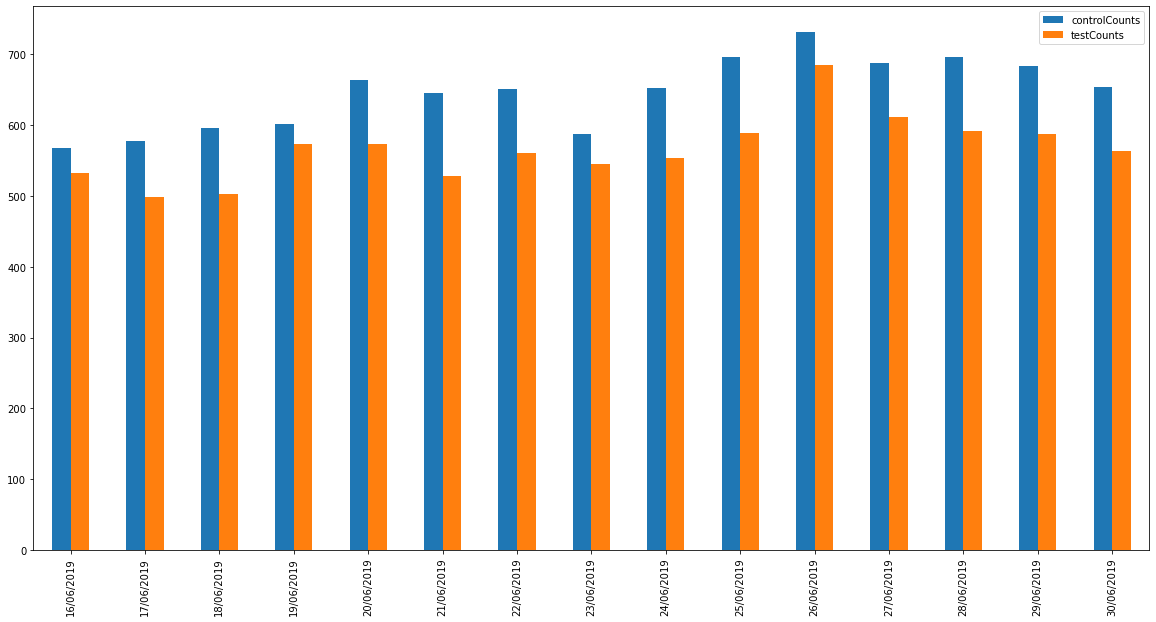

In [10]:
# Get the observation counts by date
controlCountsByDate = control.groupby('load_date').size().reset_index(name='controlCounts').set_index('load_date')
testCountsByDate = test.groupby('load_date').size().reset_index(name='testCounts').set_index('load_date')
allCountsByDate = pd.concat([controlCountsByDate, testCountsByDate], axis=1)

# Rename the index to d/m/YYYY format
allCountsByDate.index = [d.strftime("%d/%m/%Y") for d in allCountsByDate.index]

#Plot the counts
ax = allCountsByDate.plot.bar(figsize=(20, 10))

If assignment into the test and control groups was truly random with a 50% probability, we can assume that the experiment split, $X$, follow a binomial distribution:
$$
X \sim Bin(n, p)
$$

As our n is large, the binomial distribution can be approximated by the normal distribution where, 
$$
X \sim N(\mu=np, \sigma=\sqrt{np(1-p)})
$$

With the normal distribution, we can find the probability of assigning 8495 observations or fewer into the test group, given a 50% probability of assignment 

In [11]:
# Define distribution parameters
n = nControl + nTest
p = 0.5
mu = n*p
sigma = np.sqrt(n*p*(1-p))

print(' n = ',n,'\n',
    'p = ',p, '\n',
    'mu = ', mu, '\n',
    'sigma = ', sigma
)

 n =  18185 
 p =  0.5 
 mu =  9092.5 
 sigma =  67.4258852370512


The chart below shows the pdf of the normal distribution with a mean of 9092.5 and a standard deviation of 67.4. We only show the distribution range for of +/- 3 standard deviations around the mean and observe that the 8495 is more than 3 standard deviations away from the mean. In fact 8495 is more than 8.8 standard deviations away from the mean and the probability of assigning 8495 or fewer transactions to the test group given a probability of assignment of 0.5 is almost 0. 

From these results, we can conclude that it is highly unlikely that our control and test group are the result of a 50/50 random assignment process. In particular, we would be concerned that the assignment process is non-random.

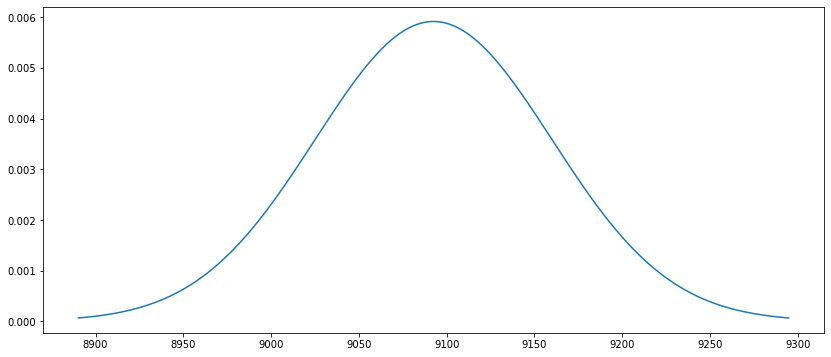

In [12]:
def plotNormal(mu, sigma):
    '''
    Plots normal distribution given mu and sigma
    '''
    fig, ax = plt.subplots(figsize=(14, 6))
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
    plt.plot(x, stats.norm.pdf(x, mu, sigma))

plotNormal(mu, sigma)

In [13]:
zScore = (nTest-mu)/sigma
testCDF = stats.norm.cdf(zScore)
print('The z score is {}.'.format(zScore))
print('The probability of randomly assigning {} or fewer participants to the test group when the probability of assignment is 0.5 is {}'. format(nTest, round(testCDF, 2)))

The z score is -8.861581837588803.
The probability of randomly assigning 8495 or fewer participants to the test group when the probability of assignment is 0.5 is 0.0


#### Conversion Rates

This section summarizes our observed conversion rates for both groups. Both the control and test groups had higher conversions than non-conversions, but the test group had a higher conversion rate on form loads.

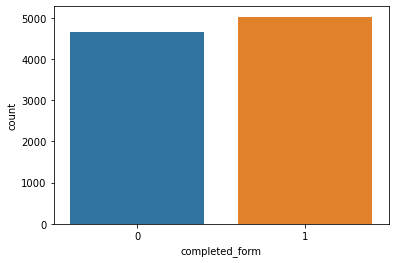

In [14]:
ax = sns.countplot(x='completed_form', data=control)

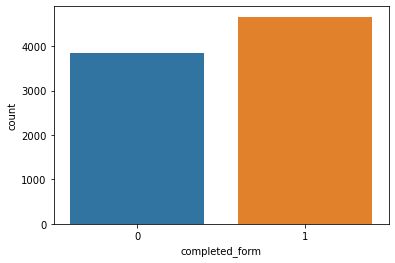

In [15]:
ax = sns.countplot(x='completed_form', data=test)

In [16]:
# Calculate conversion rates
conversionPre = pre['completed_form'].mean()
conversionControl = control['completed_form'].mean()
conversionTest = test['completed_form'].mean()
lift = conversionTest - conversionControl
print('Baseline conversion: {}'.format(conversionPre))
print('Control conversion: {}'.format(conversionControl))
print('Test conversion: {}'.format(conversionTest))
print('Observed lift: {}'.format(lift))

Baseline conversion: 0.5253207448811145
Control conversion: 0.5186790505675954
Test conversion: 0.5483225426721601
Observed lift: 0.029643492104564628


While the conversion rate in the first checkout stage of the test group seems to be higher than the control group, we are interested in the quality of conversions and if outcomes are improved across the the checkout funnel. Ideally, the new feature would ultimately lead to more sales conversions in the final stage of the funnel.

In [17]:
conversionControlSecond = control['completed_second'].sum()/control['completed_form'].sum()
conversionTestSecond = test['completed_second'].sum()/test['completed_form'].sum()
print('Control second stage conversion: {}'.format(conversionControlSecond))
print('Test second stage conversion: {}'.format(conversionTestSecond))

Control second stage conversion: 0.6707122960604854
Test second stage conversion: 0.6629454701588665


In [18]:
conversionControlFinal = control['checkout_id'].count()/control['completed_second'].sum()
conversionTestFinal = test['checkout_id'].count()/test['completed_second'].sum()
print('Control final stage conversion: {}'.format(conversionControlFinal))
print('Test final stage conversion: {}'.format(conversionTestFinal))

Control final stage conversion: 0.754375556214773
Test final stage conversion: 0.7470854922279793


In [19]:
conversionControlTotal = control['checkout_id'].count()/nControl
conversionTestTotal = test['checkout_id'].count()/nTest
print('Control Total conversion: {}'.format(conversionControlTotal))
print('Test Total conversion: {}'.format(conversionTestTotal))

Control Total conversion: 0.26243550051599585
Test Total conversion: 0.27157151265450263


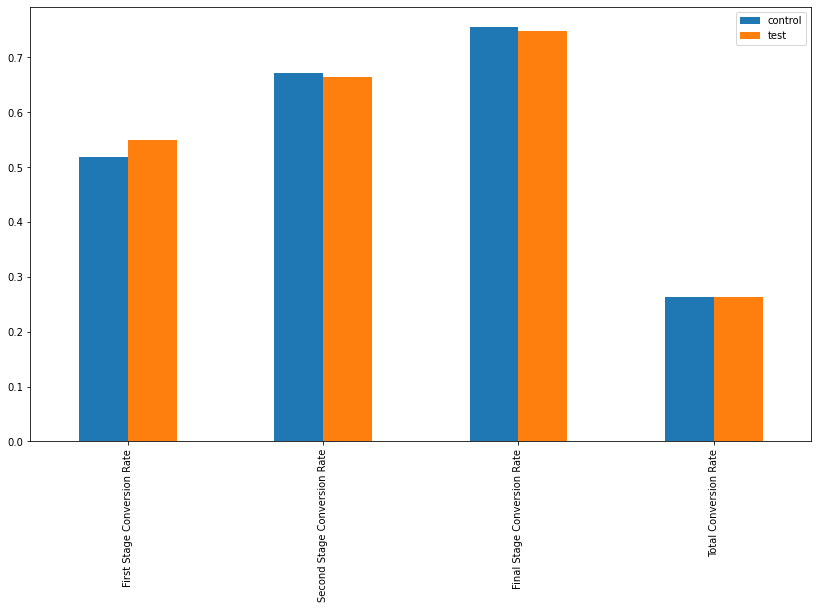

In [20]:
chartDF = pd.DataFrame(data = [[conversionControl, conversionTest],
                               [conversionControlSecond, conversionTestSecond],
                               [conversionControlFinal, conversionTestFinal],
                               [conversionControlTotal, conversionControlTotal]
                              ],
                       index = ['First Stage Conversion Rate', 
                                'Second Stage Conversion Rate', 
                                'Final Stage Conversion Rate', 
                                'Total Conversion Rate'
                               ], 
                       columns = ['control', 'test']
                      )
chartDF.plot.bar(figsize=(14, 8))

The analysis above shows that the quality of conversions could be a concern. While the test group had a higher conversion rate in the first checkout stage, leading to the test group having relatively more customers entering the checkout funnel than the control group, conversions at the second and  final checkout stages were slightly lower, resulting in a muted improvement on sales. Though the client is mainly interested in increasing conversion at the first step of the checkout funnel, given the cost of $2 per look-up of the new feature, **we should be concerned about the cost-benefit of the feature as it does not seem to improve conversions on actual sales**.

#### Statistical Testing

The section below will detail the statistical test used to analyze the experiment results.

##### Statistical Framework
Assuming a form load follow a Bernoulli distribution defined by a conversion rate (or conversion probability) $p$:
$$
X \sim Bernoulli(p)
$$
Then, the conversion rate follows a normal distribution, where:
$$
\hat{p} \sim N \left ( \mu=p, \sigma = \sqrt{\frac{p(1-p)}{n}} \right )
$$

The goal of the 5-field form is to generate a lift defined as the difference between the conversion rates between the test and control group:
$$
d = p_t - p_c
$$
where $d$ is lift of the test group over the control group, $p_t$ is the conversion rate of the test group (5-field form), and $p_c$ is the conversion rate of the control group (6-field form). 

The conversion rate, $p$, is defined as the ratio of completed forms, $X$, over total form loads, $n$:

$$
p = \frac{x}{n}
$$


To statistically analyze the lift, we conduct a hypothesis test, where the null hypothesis is that there is no lift and the alternative hypothesis is that the lift is greater than 0 to see if our results are significant. The formalized hypotheses are the following:

$$ 
H_0 : d = 0
$$

$$
H_A : d > 0
$$

As $p_t$ and $p_c$ are normally distributed, independent, and have the same variance, $d$ is normally distributed:
$$
\hat{d} \sim N \left ( \mu=d, \sigma = \sqrt{ p_{pool}(1-p_{pool}) \left ( \frac{1}{n_c}+\frac{1}{n_t} \right ) } \right )
$$
where $p_{pool} = \frac{x_c+x_t}{n_c+n_t}$.


Given the normal distribution of $d$, we can calculate a z test statistic for the hypothesis test:
$$
z = \frac{\hat{d}-0}{\sqrt{ p_{pool}(1-p_{pool}) \left ( \frac{1}{n_c}+\frac{1}{n_t} \right ) }}
$$
For the hypothesis test, we assume a significance level ($\alpha$) of 0.05. This means that we are willing to tolerate Type I errors, or false positive results, 5% of the time. If the p-value, or the probability of observing lift as or more extreme than the observed lift, is smaller than our sigificance level, we conclude that our results are statistically significant.

##### Power Analysis
Before we began the experiment, we should have first considered the power of our experiment.

Power is the defined as the probability of rejecting the null hypothesis, given that it is false. Normally, power is calculated as the following:

$$
Power = 1 - P(Type II error)
$$

In the context of our desired experiment on form loads, power is the probability of correctly concluding that our new test feature creates a lift in the conversion rate compared to control.

One of the harder to grasp concepts related to power is that **power is determined ex-ante to analyzing the actual results of the experiment and conditional on some counterfactual true effect and variance that is not observed, and the probability of Type I error ($\alpha$)**. That is, we never know the 'true' power of our experiment as we will never know the true parameters of the population. If we can only determine ex-ante power, why is power analysis useful?

Ex-ante power analysis is useful because before you even start the experiment and observe any results, power analysis tells you if your experiment design is 'good enough' for what you setting out to accomplish. The most typical application for power-analysis in A/B testing is in the context of sample size determination. Given that we believe that our new feature is going to result in some lift, for example 3 percentage points, is our planned sample size large enough to detect such a lift. The larger the sample size, the more likely would our experiment be able to detect this counterfactual lift. It is standard to assume $\alpha=0.05$ and $power=0.80$ to be acceptable for an experiment, but these values can change depending on the preferences of the experimenter.

In the example below, we calculate a power of 0.38 assuming that the baseline conversion rate of 52.5% is the baseline conversion rate, the true lift is 3 percentage points, 1000 observations per split in the experiment, and $\alpha=0.05$. This means that even if the true lift is 3%, the null hypothesis will only be rejected the null hypothesis 38% of the time if we only collect 1000 observations per group. To achieve a power of 0.8 we must increase the sample size of our experiment.

The chart also illustrates how power is affected by the effect of the alternative hypothesis and $\alpha$. If the alternative hypothesis effect is larger and further away from the null hypothesis, the power of our test increases. If the $\alpha$, or probability of type 1 error increases, our power increases as we are more likely to reject the null hypothesis.

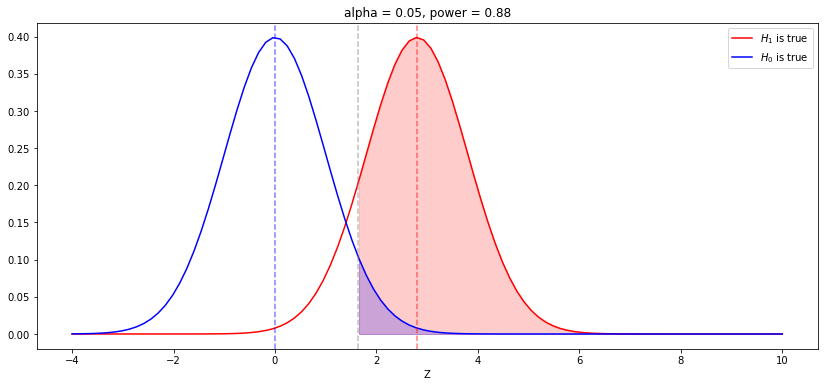

In [21]:
def powerPlot(baseline, d, nC, nT, alpha):
    '''
    Plots null and alternative hypothesis with p-value and power shaded
    
    Parameters
    ---
    baseline: float
        Baseline conversion rate
    d: float
        Counterfactual lift observed
    nC: int
        Number of observations in control group
    nT: int
        Number of observations in test group
    alpha: float
        Chosen alpha level
    '''
    
    # Calculate Z stat
    xC = nC*baseline
    xT = nT*(baseline+d)
    pPool = (xC+xT)/(nC + nT)
    sePool = np.sqrt((pPool*(1-pPool))*(1/nC+1/nT))
    zStat = d/sePool
    
    # define null and alternative distributions
    h0 = stats.norm(loc = 0, scale = 1)
    h1 = stats.norm(loc = zStat, scale = 1)
    fig, ax = plt.subplots(figsize=(14, 6))
    zCritical = h0.ppf(1 - alpha)
    power = 1 - h1.cdf(zCritical)
    x = np.linspace(-4, 10, 100)
    mask = x > zCritical
    hypotheses = [h1, h0]
    labels = ['$H_1$ is true', '$H_0$ is true']
    colors = ['red', 'blue']
    for hypothesis, label, color in zip(hypotheses, labels, colors):
        y = hypothesis.pdf(x)
        line = plt.plot(x, y, label = label, color=color)  
        plt.fill_between(x = x[mask], y1 = 0.0, y2 = y[mask],
                         alpha = 0.2, color = color)
    ax.axvline(x=0, c='blue', alpha=0.5, linestyle='--')
    ax.axvline(x=zStat, c='red', alpha=0.5, linestyle='--')
    ax.axvline(x=zCritical, c='grey', alpha=0.5, linestyle='--')
    plt.legend()
    plt.title('alpha = {}, power = {}'.format(alpha, round(power,2)))
    plt.xlabel('Z')

d = 0.03
nC = 4330
nT = 4330
alpha = 0.05
powerPlot(conversionPre, d, nC, nT, alpha)

Python does not have a built in tool like R to calculate minumum sample sizes, but there are plenty of tools, such as https://www.evanmiller.org/ab-testing/sample-size.html that help with this. Using this tool, we find that we need a minimum sample size of 4,351 given a baseline conversion rate of 0.525, a minimum detectable effect of 0.03, power of 0.80, and a significance level of 0.05. Our current sample size of 8,000+ observations in each of the control and test group well surpases the sample size requirement. 

If the magnitude of the minimum detectable effect is smaller, the minimum sample size also increases, e.g. a minimum detectable effect of 0.02 percentage points requires 9,790 observations per variation. 

##### Hypothesis Testing

In this section, I conduct a hypothesis test on the form load data and interpret the results.

In [22]:
# Define function for A/B hypothesis test

def twoProportionTest(xControl, xTest, nControl, nTest, alpha=0.05):
    '''
    Function to perform one-tailed A/B hypothesis test for two sample proportions.
    
    Parameters
    ----------
    xControl, xTest: int
        Number of successful conversions in control and test groups
    nControl, nTest: int
        Total number of trials in control and test groups
    alpha: float
        Significance level, default is 0.05
        
    Returns
    -------
    lift: float
        observed lift between test and control group
    zStat: int
        z statistic of hypothesis test
    pVal: float
        p-value or probability of type I error
    statSig: bool
        True if test is statistically at alpha
    '''
    pControl = xControl / nControl
    pTest = xTest / nTest
    pPool = (xControl + xTest) / (nControl + nTest)
    lift = abs(pTest - pControl)
    sePool = np.sqrt((pPool * (1-pPool)) * (1/nControl+1/nTest))
    zStat = lift / sePool
    pVal = stats.norm.sf(abs(zStat))
    statSig = pVal < alpha
    print('The observed lift between the control group and test group is {}'.format(round(lift, 4)))
    print('The z test statistic is {} and the p-value is {}'.format(round(zStat, 3), round(pVal, 4)))
    if statSig:
        print('Test conclusion: p<alpha, the lift is statistically significant at a significance level of {}'.format(alpha))
    else:
        print('Test conclusion: p>alpha, the lift is not statistically significant at a significance level of {}'.format(alpha))
    return lift, zStat, pVal, statSig

# Plot
def twoProportionPlot(zStat, alpha=0.05):
    '''
    Function to plot the two proportions hypothesis test.
    
    Parameters
    ---
    zStat: float
        Z test statistic of the two proportions test
    '''
    # Define distribution parameters
    h0 = stats.norm(loc = 0, scale = 1)
    zCritical = h0.ppf(1 - alpha)
    x = np.linspace(-4, 4, 100)
    mask = x > zCritical
    y=h0.pdf(x)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    line = plt.plot(x, y, color = 'blue')
    plt.fill_between(x = x[mask], y1 = 0.0, y2 = y[mask],
                         alpha = 0.2, color = 'blue')
    ax.axvline(x=0, c='blue', alpha=0.5, linestyle='--')
    ax.axvline(x=zStat, c='red', alpha=0.5, linestyle='--')
    ax.axvline(x=zCritical, c='grey', alpha=0.5, linestyle='--')
    plt.text(zStat, 0.2, "Z Test Stat: {}".format(round(zStat,2)), 
             rotation=90, verticalalignment='center')
    plt.text(zCritical, 0.2, "Z Critical Value: {}".format(round(zCritical,2)), 
             rotation=90, verticalalignment='center')

The observed lift between the control group and test group is 0.0296
The z test statistic is 3.997 and the p-value is 0.0
Test conclusion: p<alpha, the lift is statistically significant at a significance level of 0.05


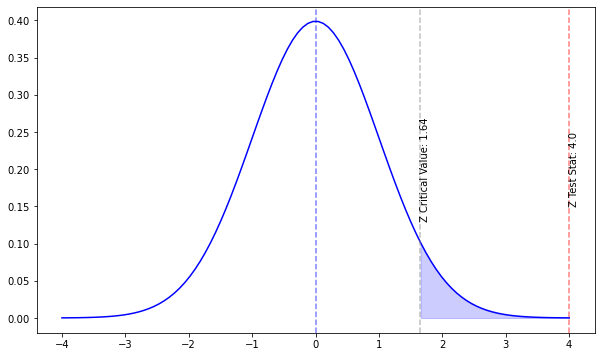

In [23]:
# Conduct hypothesis test
xControl = control['completed_form'].sum()
xTest = test['completed_form'].sum()
lift, zStat, pVal, statSig = twoProportionTest(xControl, xTest, nControl, nTest)

#Plot
twoProportionPlot(zStat)

Our results show that the 5-field form in the test group resulted in a lift of 3 percentage points in the proportion of completed forms to form loads compared to the control group receiving the 6-field form. This result is statistically significant at the 5% level (blue shaded region in plot) and a even stricter than the 1% level, leading us to reject the null hypothesis that there was no lift between the two form variations.

Following up this analysis, it is necessary to consider the total conversion rate through the entire funnel. Since the 5-field form feature will cost $2 for each applicant passing throught the first stage of the checkout funnel, a thorough cost-benefit analysis should be conducted. Preliminary analysis indicates that conversion in the first stage of the funnel does not translate into conversions into sales. If this is the case, implementing the 5-field form will result in a negative impact on profits.